<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Optional part
## <center> Implementation of the decision tree algorithm

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [32]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
    
    A functional to be maximized to find an optimal partition at a given node has the form
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
    For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
    
    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
    
    'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

In [33]:
def entropy(y):    
    classes, counts=np.unique(y,return_counts=True)
    prob=counts/counts.sum()
    return -np.sum(prob*np.log(prob))

def gini(y):
    classes, counts=np.unique(y,return_counts=True)
    prob=counts/counts.sum()
    return 1-np.sum(prob*prob)

def variance(y):
    return np.var(y)

def mad_median(y):
    return np.sum(np.abs(y-np.mean(y)))/len(y)

In [34]:
y=np.asarray([1,1,2,2,3,3])
# print(y.var())
mad_median(y)

0.6666666666666666

The `Node` class implements a node in the decision tree.

In [35]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [136]:
class DecisionTree(BaseEstimator):
    criterion_dict={'gini':gini,'entropy':entropy,'variance':variance,'mad_median':mad_median}
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.criterion=criterion
    
    def __split(self,X,y):
        if len(y)<=self.min_samples_split or len(np.unique(y))==1:
            return Node(labels=y)
        crit=self.criterion_dict[self.criterion]
        raw_gain=0
        raw_index=None
        raw_value=None
        tmp_X_left=None
        tmp_X_right=None
        tmp_y_left=None
        tmp_y_right=None
        for index_id,i in enumerate(X.T):
            u=np.unique(i)
            if u[0].dtype=='O':
                sign=lambda x,y:x==y
            else:
                sign=lambda x,y:x<=y
            raw=crit(y)
            for j in u:
                index = sign(i,j)
                X_left,y_left = X[index],y[index]
                X_right,y_right = X[~index],y[~index]
                new=len(y_left)/len(y)*crit(y_left)+len(y_right)/len(y)*crit(y_right)
                gain=raw-new
                if(gain>raw_gain):
                    raw_gain=gain
                    raw_index=index_id
                    raw_value=j
                    tmp_X_left=X_left
                    tmp_X_right=X_right
                    tmp_y_left=y_left
                    tmp_y_right=y_right
        left_node=self.__split(tmp_X_left,tmp_y_left)
        right_node = self.__split(tmp_X_right,tmp_y_right)
        return Node(feature_idx=raw_index,threshold=raw_value,left=left_node,right=right_node)
    def fit(self, X, y):
        self.root=self.__split(X,y)
        return self
    
    def __get_labels(self,X):
        l=[]
        for i in X:
            node = self.root
            while node.labels is None:
                index=node.feature_idx
                if i[index].dtype=='O':
                    sign=lambda x,y:x==y
                else:
                    sign=lambda x,y:x<=y
                if sign(i[index],node.threshold):
                    node=node.left
                else:
                    node=node.right
            else:
                l.append(node.labels)
        return l
    def predict(self, X):
        l=self.__get_labels(X)
        tmp=[]
        for i in l:
            uniq,counts=np.unique(i,return_counts=True)
            result = uniq[np.argmax(counts)] if self.criterion in ('gini','entropy') else np.mean(i)
            tmp.append()
        return tmp
        
    def predict_proba(self, X):
        l=self.__get_labels(X)
        tmp=[]
        for i in l:
            uniq,counts=np.unique(i,return_counts=True)
            tmp.append(np.max(counts)/np.sum(counts))
        return tmp

## Testing the implemented algorithm

### Classification

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [49]:
from sklearn.datasets import load_digits
digits=load_digits()

In [60]:
X=np.arange(10).reshape(-1,1)
y=np.where(X>5,1,0)

In [68]:
tmp_node = tree.root

def print_node(tmp_node):
    if tmp_node is None:
        return
    print("feature_idx:",tmp_node.feature_idx)
    print("threshold:",tmp_node.threshold)
    print("labels:",tmp_node.labels)
    print_node(tmp_node.left)
    print_node(tmp_node.right)
print_node(tmp_node)

feature_idx: 0
threshold: 5
labels: None
feature_idx: 0
threshold: 0
labels: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]]
feature_idx: 0
threshold: 0
labels: [[1]
 [1]
 [1]
 [1]]


In [85]:
tree=DecisionTree()
tree.fit(X,y)

DecisionTree(criterion='gini', debug=None, max_depth=inf, min_samples_split=2)

In [86]:
from sklearn.metrics import precision_score
y_pred=tree.predict(X)
print(y_pred)
print(precision_score(y,y_pred,average='macro'))

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
1.0


In [87]:
X,y=digits['data'],digits['target']
tree=DecisionTree()
tree.fit(X,y)

DecisionTree(criterion='gini', debug=None, max_depth=inf, min_samples_split=2)

In [89]:
from sklearn.metrics import precision_score
y_pred=tree.predict(X)
print(precision_score(y,y_pred,average='macro'))

0.9906685394426482


In [95]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=17)

In [96]:
tree_gini=DecisionTree(criterion='gini')
tree_gini.fit(X_train,y_train)
from sklearn.metrics import precision_score
y_test_pred=tree_gini.predict(X_test)
print(precision_score(y_test,y_test_pred,average='macro'))

0.8262238779425009


In [98]:
tree_entro=DecisionTree(criterion='entropy')
tree_entro.fit(X_train,y_train)
from sklearn.metrics import precision_score
y_test_pred_entro=tree_entro.predict(X_test)
print(precision_score(y_test,y_test_pred_entro,average='macro'))

0.8870943391896118


In [93]:
from sklearn.tree import DecisionTreeClassifier
dtD = DecisionTreeClassifier(min_samples_split=2)
dtD.fit(X_train,y_train)
y_test_pred_sk=dtD.predict(X_test)
print(precision_score(y_test,y_test_pred_sk,average='macro'))

0.8346398252844527


In [94]:
from ipywidgets import Image
import pydotplus
from sklearn.tree import export_graphviz
from io import StringIO
dot_data=StringIO()
export_graphviz(dtD,feature_names=['x{}'.format(i) for i in range(X.shape[1])],out_file=dot_data)
graph=pydotplus.graph_from_dot_data(dot_data)
Image(value=graph.create_pnd())

ModuleNotFoundError: No module named 'pydotplus'

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

In [101]:
from sklearn.model_selection import GridSearchCV
param_grid=[{'max_depth':[i for i in range(3,11)],'criterion':['gini', 'entropy']}]
tree=DecisionTree()
gCV=GridSearchCV(tree,param_grid=param_grid,cv=5,scoring='accuracy')
gCV.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTree(criterion='gini', debug=None, max_depth=inf, min_samples_split=2),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [104]:
y_test_best_predict=gCV.best_estimator_.predict(X_test)
print(precision_score(y_test,y_test_best_predict,average='macro'))

0.8870943391896118


Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

In [123]:
l=list(zip(gCV.cv_results_['params'],gCV.cv_results_['mean_test_score']))
gini_l=l[:8]
entro_l=l[8:]
print(gini_l)
print(entro_l)

[({'criterion': 'gini', 'max_depth': 3}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 4}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 5}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 6}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 7}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 8}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 9}, 0.8322894919972165), ({'criterion': 'gini', 'max_depth': 10}, 0.8322894919972165)]
[({'criterion': 'entropy', 'max_depth': 3}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 4}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 5}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 6}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 7}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 8}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 9}, 0.8643006263048016), ({'criterion': 'entropy', 'max_depth': 10}, 0.864300626304801

In [126]:
gCV.cv_results_['mean_test_score']

array([0.83228949, 0.83228949, 0.83228949, 0.83228949, 0.83228949,
       0.83228949, 0.83228949, 0.83228949, 0.86430063, 0.86430063,
       0.86430063, 0.86430063, 0.86430063, 0.86430063, 0.86430063,
       0.86430063])

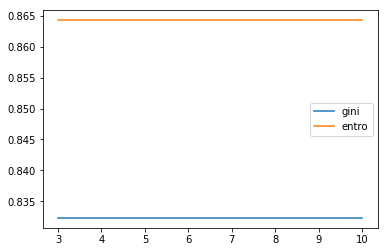

In [127]:
plt.plot([i[0]['max_depth'] for i in gini_l],[i[1] for i in gini_l],label='gini')
plt.plot([i[0]['max_depth'] for i in entro_l],[i[1] for i in entro_l],label='entro')
plt.legend()

**1. Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.
2. Created plots have no intersection on the interval [3, 10]
3. Created plots intersect each other only once on the interval [3, 10].
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]

**2. What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [9]:
# You code here

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [10]:
# You code here

**3. What is the maximum probability in a resulted vector?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

## Regression

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [128]:
from sklearn.datasets import load_boston
boston=load_boston()

In [132]:
X,y=boston['data'],boston['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=17)

In [137]:
from sklearn.metrics import mean_absolute_error
tree_var=DecisionTree(criterion='variance')
tree_var.fit(X_train,y_train)
from sklearn.metrics import precision_score
y_test_pred=tree_var.predict(X_test)
print(mean_absolute_error(y_test,y_test_pred))


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: append() takes exactly one argument (0 given)

Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [12]:
# You code here

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

In [13]:
# You code here

**4. Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. Created plots intersect each other only once on the interval [2, 8].
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.

**5. What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.